In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=125
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)
A=mk_laplace_1d(dim)
AType='1D Laplacian'

retrain_freq=1
e1 = 1e-4
e2 = 1e-7
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =2000
InputDim=dim
HiddenDim=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC.")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-11 19:42:36 [INFO] <ipython-input-4-44a99f37ffba> 2 - Benchmark 125 dim problem. Linear gradient RHS. Test 1D linop. Benchmark on Kevin's PC.


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *



ML_GMRES_Time_list=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
#     b=Gauss_pdf(x,loc,sigma)
    b=(np.sin(ProbIdx)+.0001)*np.maximum(x-loc,0)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)
    



    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[50])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)
    
    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
Final loss: 5625.2880859375
parameters 31250
Initial Training
2
size 52
0.020910996732676213 0.3367121113433218
0.32204131700564176 0.5498372735019075 0.020910996732676213 0.22228070966830848
0.32204131700564176 0.5498372735019075 0.020910996732676213 0.22228070966830848
3
size 52
0.08741394920652176 0.3367121113433218
0.47301824000896886 0.4422747610078659 0.08741394920652176 0.11553278737516809
0.47301824000896886 0.4422747610078659 0.08741394920652176 0.11553278737516809
4
size 52
0.04416631229804397 0.3367121113433218
0.36057274299673736 0.45252258734156686 0.04416631229804397 0.10615984131895266
0.36057274299673736 0.45252258734156686 0.04416631229804397 0.10615984131895266
5
size 52
0.21439274945090916 0.3367121113433218
0.44344144401839003 0.38521076667044934 0.21439274945090916 0.05083041941241398
0.44344144401839003 0.38521076667044934 0.21439274945090916 0.05083041941241398
6
size 52
0.051129839869101155 0.3367121113433218
0.4624210210167803 0.3997684360074345 0.051129839

0.23523879700223915 0.38156463040038946 0.021518853419611208 0.06580279460488687
39
size 52
0.057687134969369266 0.3367121113433218
0.511611374997301 0.36869546356028876 0.057687134969369266 0.060428969128433374
0.511611374997301 0.36869546356028876 0.057687134969369266 0.060428969128433374
40
size 52
0.08604280707113367 0.3367121113433218
0.34210926698870026 0.3769670767604839 0.08604280707113367 0.0625190476912992
0.34210926698870026 0.3769670767604839 0.08604280707113367 0.0625190476912992
41
size 52
0.03595171932894091 0.3367121113433218
0.3104231930046808 0.3718353800394107 0.03595171932894091 0.06270317412245911
0.3104231930046808 0.3718353800394107 0.03595171932894091 0.06270317412245911
42
size 52
0.024245172654596383 0.3367121113433218
0.40713463400607 0.36179133171914146 0.024245172654596383 0.055206098484708394
0.40713463400607 0.36179133171914146 0.024245172654596383 0.055206098484708394
43
size 52
0.027668469141237533 0.3367121113433218
0.22433357199770398 0.35851460083969

76
size 52
0.019711161260964644 0.3367121113433218
0.20221616700291634 0.32077738280175255 0.019711161260964644 0.030530992249163315
0.20221616700291634 0.32077738280175255 0.019711161260964644 0.030530992249163315
77
size 52
0.011803683350205506 0.3367121113433218
0.2271133520116564 0.3193706843617838 0.011803683350205506 0.030561150207655645
0.2271133520116564 0.3193706843617838 0.011803683350205506 0.030561150207655645
78
size 52
0.012326590006559356 0.3367121113433218
0.35192435097997077 0.31822946288157256 0.012326590006559356 0.03063069850722282
0.35192435097997077 0.31822946288157256 0.012326590006559356 0.03063069850722282
79
size 52
0.053030167539448086 0.3367121113433218
0.32263425100245513 0.3180071508814581 0.053030167539448086 0.02768379062632534
0.32263425100245513 0.3180071508814581 0.053030167539448086 0.02768379062632534
80
size 52
0.010749908060678773 0.3367121113433218
0.2422629710054025 0.3124834386422299 0.010749908060678773 0.026746219498179125
0.2422629710054025 

0.28807556300307624 0.2758478791208472 0.01195939982071243 0.017551284873294624
113
size 52
0.01771039945038208 0.3367121113433218
0.3557577910250984 0.27776158016058616 0.01771039945038208 0.01702764360213229
0.3557577910250984 0.27776158016058616 0.01771039945038208 0.01702764360213229
114
size 52
0.014503405019513773 0.3367121113433218
0.28368775398121215 0.28234545268234795 0.014503405019513773 0.016881488391030697
0.28368775398121215 0.28234545268234795 0.014503405019513773 0.016881488391030697
115
size 52
0.012401241126741172 0.3367121113433218
0.20518639299552888 0.2805408854817506 0.012401241126741172 0.016397036167167135
0.20518639299552888 0.2805408854817506 0.012401241126741172 0.016397036167167135
116
size 52
0.012065539410855693 0.3367121113433218
0.353490748006152 0.2778203080012463 0.012065539410855693 0.01621716366305205
0.353490748006152 0.2778203080012463 0.012065539410855693 0.01621716366305205
117
size 52
0.021377642727057736 0.3367121113433218
0.3198287459963467 0.

0.20466374000534415 0.24622249076142907 0.0014592235783946975 0.010006785068985447
150
size 52
0.014505984142179492 0.3367121113433218
0.35475246599526145 0.24216199204092845 0.014505984142179492 0.009746583830515194
0.35475246599526145 0.24216199204092845 0.014505984142179492 0.009746583830515194
151
size 52
0.013811483250645374 0.3367121113433218
0.2783664299931843 0.25019880359992386 0.013811483250645374 0.010164427862138368
0.2783664299931843 0.25019880359992386 0.013811483250645374 0.010164427862138368
152
size 52
0.014107676643687268 0.3367121113433218
0.24394353799289092 0.25088537800009364 0.014107676643687268 0.010104389500108543
0.24394353799289092 0.25088537800009364 0.014107676643687268 0.010104389500108543
153
size 52
0.004124864372318643 0.3367121113433218
0.24340697098523378 0.25009591080015525 0.004124864372318643 0.010006017580400652
0.24340697098523378 0.25009591080015525 0.004124864372318643 0.010006017580400652
154
size 52
0.007469324762729421 0.3367121113433218
0.2

186
size 52
0.012197593713249102 0.3367121113433218
0.23819119899417274 0.22895224024076014 0.012197593713249102 0.006231099319386209
0.23819119899417274 0.22895224024076014 0.012197593713249102 0.006231099319386209
187
size 52
0.004747223547448031 0.3367121113433218
0.2337801420071628 0.23028018488083035 0.004747223547448031 0.006573462614896037
0.2337801420071628 0.23028018488083035 0.004747223547448031 0.006573462614896037
188
size 52
0.007187573967352036 0.3367121113433218
0.266531899018446 0.2348096654820256 0.007187573967352036 0.006598452692355708
0.266531899018446 0.2348096654820256 0.007187573967352036 0.006598452692355708
189
size 52
0.00692565709491666 0.3367121113433218
0.23448367498349398 0.23739092332194558 0.00692565709491666 0.006544558747742988
0.23448367498349398 0.23739092332194558 0.00692565709491666 0.006544558747742988
190
size 52
0.018209957722613735 0.3367121113433218
0.6066149149846751 0.23249614520231263 0.018209957722613735 0.00626937938682571
0.6066149149846

0.30250956799136475 0.20836547195678576 0.006317500896268978 0.005691648090322221
223
size 52
0.0017679931852961684 0.3367121113433218
0.12271927497931756 0.21560837363591417 0.0017679931852961684 0.005819516619443289
0.12271927497931756 0.21560837363591417 0.0017679931852961684 0.005819516619443289
224
size 52
0.004254768187426947 0.3367121113433218
0.1632681020128075 0.21403735171537847 0.004254768187426947 0.0057957853967518505
0.1632681020128075 0.21403735171537847 0.004254768187426947 0.0057957853967518505
225
size 52
0.00492469147289708 0.3367121113433218
0.20270657099899836 0.2143872431560885 0.00492469147289708 0.00574801594231361
0.20270657099899836 0.2143872431560885 0.00492469147289708 0.00574801594231361
226
size 52
0.004414655244775954 0.3367121113433218
0.24472555000102147 0.21438470843597315 0.004414655244775954 0.00571909735421537
0.24472555000102147 0.21438470843597315 0.004414655244775954 0.00571909735421537
227
size 52
0.00548954888684765 0.3367121113433218
0.2045424

0.3092251740163192 0.21436628072173336 0.004174948811022964 0.004964833664535681
0.3092251740163192 0.21436628072173336 0.004174948811022964 0.004964833664535681
260
size 52
0.00526959721356912 0.3367121113433218
0.13207222300115973 0.21443382152239793 0.00526959721356912 0.004702007577130753
0.13207222300115973 0.21443382152239793 0.00526959721356912 0.004702007577130753
261
size 52
0.004066777590033561 0.3367121113433218
0.22360722802113742 0.21183384808246047 0.004066777590033561 0.004571588805107888
0.22360722802113742 0.21183384808246047 0.004066777590033561 0.004571588805107888
262
size 52
0.0033185663117973906 0.3367121113433218
0.15475954802241176 0.21273249940364622 0.0033185663117973906 0.004647910116151004
0.15475954802241176 0.21273249940364622 0.0033185663117973906 0.004647910116151004
263
size 52
0.003559337909788569 0.3367121113433218
0.21725617599440739 0.2123715880443342 0.003559337909788569 0.00449138055721524
0.21725617599440739 0.2123715880443342 0.00355933790978856

0.17571359398425557 0.19585229500196874 0.003023318454610222 0.004073090860010605
296
size 52
0.0032547443351251394 0.3367121113433218
0.25386690499726683 0.19412481716135516 0.0032547443351251394 0.003747938746296354
0.25386690499726683 0.19412481716135516 0.0032547443351251394 0.003747938746296354
297
size 52
0.002759666837519053 0.3367121113433218
0.17140027400455438 0.19731599004124292 0.002759666837519053 0.003746288125075083
0.17140027400455438 0.19731599004124292 0.002759666837519053 0.003746288125075083
298
size 52
0.004001844252220987 0.3367121113433218
0.17469235599855892 0.19723720432142727 0.004001844252220987 0.003693766760973006
0.17469235599855892 0.19723720432142727 0.004001844252220987 0.003693766760973006
299
size 52
0.0026909988876929053 0.3367121113433218
0.20517887399182655 0.19806751156109384 0.0026909988876929053 0.003662193648109485
0.20517887399182655 0.19806751156109384 0.0026909988876929053 0.003662193648109485
300
size 52
0.002492808223393608 0.3367121113433

332
size 52
0.0017796791441845282 0.3367121113433218
0.1937400710012298 0.16976991443894804 0.0017796791441845282 0.002691885310341394
0.1937400710012298 0.16976991443894804 0.0017796791441845282 0.002691885310341394
333
size 52
0.004371301689264222 0.3367121113433218
0.2539644339994993 0.1689040472789202 0.004371301689264222 0.002594512660288696
0.2539644339994993 0.1689040472789202 0.004371301689264222 0.002594512660288696
334
size 52
0.0029770028940516585 0.3367121113433218
0.17524355399655178 0.17081677731941455 0.0029770028940516585 0.002691528737728193
0.17524355399655178 0.17081677731941455 0.0029770028940516585 0.002691528737728193
InnerProd [[ 1.         -0.99533214 -0.95713252]
 [-0.99533214  1.          0.9771912 ]
 [-0.95713252  0.9771912   1.        ]]
retraining
1
Final loss: 308.7276611328125
parameters 31250
335
size 52
0.0023515596942813876 0.3367121113433218
0.2557835259940475 0.16760592127917334 0.0023515596942813876 0.0026953502016837205
0.2557835259940475 0.1676059

0.08062209098716266 0.16157545712194404 0.0012790446398666412 0.0024486889129865207
368
size 52
0.0013698251400939582 0.3367121113433218
0.15478567001991905 0.15854500968125648 0.0013698251400939582 0.0023837619067359826
0.15478567001991905 0.15854500968125648 0.0013698251400939582 0.0023837619067359826
369
size 52
0.002388614727000232 0.3367121113433218
0.11979601200437173 0.15775389044196345 0.002388614727000232 0.002371813076155213
0.11979601200437173 0.15775389044196345 0.002388614727000232 0.002371813076155213
370
size 52
0.0023551218942822675 0.3367121113433218
0.11998466300428845 0.15430309876101092 0.0023551218942822675 0.002395197742759087
0.11998466300428845 0.15430309876101092 0.0023551218942822675 0.002395197742759087
371
size 52
0.0024198505861787413 0.3367121113433218
0.12048971198964864 0.14892151492182165 0.0024198505861787413 0.0023646989075450193
0.12048971198964864 0.14892151492182165 0.0024198505861787413 0.0023646989075450193
372
size 52
0.002535611144445535 0.3367

0.07979136300855316 0.14145790936076083 0.0027537161871165716 0.002069412017056914
403
size 52
0.0023753067397630375 0.3367121113433218
0.16178653200040571 0.1398009977210313 0.0023753067397630375 0.0021402028082874998
0.16178653200040571 0.1398009977210313 0.0023753067397630375 0.0021402028082874998
404
size 52
0.002971156697445034 0.3367121113433218
0.12080401100683957 0.1414673560403753 0.002971156697445034 0.002169665888753673
0.12080401100683957 0.1414673560403753 0.002971156697445034 0.002169665888753673
405
size 52
0.0010426894964195037 0.3367121113433218
0.154930114018498 0.1400923956814222 0.0010426894964195037 0.0021959537457270657
0.154930114018498 0.1400923956814222 0.0010426894964195037 0.0021959537457270657
406
size 52
0.0013097630731630794 0.3367121113433218
0.16124206397216767 0.14331689492217264 0.0013097630731630794 0.0021614348236260756
0.16124206397216767 0.14331689492217264 0.0013097630731630794 0.0021614348236260756
407
size 52
0.0012238425967085946 0.336712111343

0.1541417400003411 0.1533859906368889 0.0009525554490037953 0.0019375560344375134
438
size 52
0.002265278753829833 0.3367121113433218
0.20683924600598402 0.15135848839767277 0.002265278753829833 0.0019121748224311549
0.20683924600598402 0.15135848839767277 0.002265278753829833 0.0019121748224311549
439
size 52
0.0030067707388962703 0.3367121113433218
0.12602819199673831 0.15154329667799174 0.0030067707388962703 0.001930071553872423
0.12602819199673831 0.15154329667799174 0.0030067707388962703 0.001930071553872423
440
size 52
0.002308040811587514 0.3367121113433218
0.15415238300920464 0.1516654713184107 0.002308040811587514 0.0019526933265492095
0.15415238300920464 0.1516654713184107 0.002308040811587514 0.0019526933265492095
441
size 52
0.0021947231586718977 0.3367121113433218
0.12471045900019817 0.15158095003920607 0.0021947231586718977 0.0019210425690565401
0.12471045900019817 0.15158095003920607 0.0021947231586718977 0.0019210425690565401
442
size 52
0.0018182036123523472 0.33671211

0.17424350799410604 0.14911344188265502 0.001890475932809575 0.0017000773999108357
474
size 52
0.0025863106705239685 0.3367121113433218
0.20429091801634058 0.15033516776165926 0.0025863106705239685 0.0016988491908126971
0.20429091801634058 0.15033516776165926 0.0025863106705239685 0.0016988491908126971
InnerProd [[ 1.          0.97119449 -0.99966304]
 [ 0.97119449  1.         -0.96563263]
 [-0.99966304 -0.96563263  1.        ]]
retraining
1
Final loss: 229.7474822998047
parameters 31250
475
size 52
0.0012831539696923546 0.3367121113433218
0.13386613898910582 0.15441490800236352 0.0012831539696923546 0.0017681666443959845
0.13386613898910582 0.15441490800236352 0.0012831539696923546 0.0017681666443959845
476
size 52
0.001753360149437981 0.3367121113433218
0.13251075899461284 0.15458105896250346 0.001753360149437981 0.0017446674239115492
0.13251075899461284 0.15458105896250346 0.001753360149437981 0.0017446674239115492
477
size 52
0.001357933982316176 0.3367121113433218
0.153814712015446

508
size 52
0.0022239458659042014 0.3367121113433218
0.2052016929956153 0.15458268464077263 0.0022239458659042014 0.0017715869340838948
0.2052016929956153 0.15458268464077263 0.0022239458659042014 0.0017715869340838948
509
size 52
0.0017469835533065242 0.3367121113433218
0.15480601298622787 0.15955097932019272 0.0017469835533065242 0.0017871697345392499
0.15480601298622787 0.15955097932019272 0.0017469835533065242 0.0017871697345392499
510
size 52
0.002760451296481514 0.3367121113433218
0.17989086400484666 0.15762267935904675 0.002760451296481514 0.0017585304933003124
0.17989086400484666 0.15762267935904675 0.002760451296481514 0.0017585304933003124
511
size 52
0.0022899334643536663 0.3367121113433218
0.15658943000016734 0.16173711671843194 0.0022899334643536663 0.0017936137887054426
0.15658943000016734 0.16173711671843194 0.0022899334643536663 0.0017936137887054426
512
size 52
0.0007202535670102574 0.3367121113433218
0.15375680799479596 0.1631575644784607 0.0007202535670102574 0.00185

543
size 52
0.001035495061319681 0.3367121113433218
0.15387942199595273 0.14277766311774032 0.001035495061319681 0.0015844656854145359
0.15387942199595273 0.14277766311774032 0.001035495061319681 0.0015844656854145359
544
size 52
0.001827338224508366 0.3367121113433218
0.11954976001288742 0.1427407803584356 0.001827338224508366 0.0015575901237881134
0.11954976001288742 0.1427407803584356 0.001827338224508366 0.0015575901237881134
545
size 52
0.0003921109442289516 0.3367121113433218
0.08192938199499622 0.14391530571854674 0.0003921109442289516 0.0016023996699307374
0.08192938199499622 0.14391530571854674 0.0003921109442289516 0.0016023996699307374
546
size 52
0.0008482892097764307 0.3367121113433218
0.10257300900411792 0.14361674891784787 0.0008482892097764307 0.0015919852451211545
0.10257300900411792 0.14361674891784787 0.0008482892097764307 0.0015919852451211545
547
size 52
0.0010885335597351985 0.3367121113433218
0.12028213500161655 0.14152650159900076 0.0010885335597351985 0.0015183

0.12280081200879067 0.12934974767966195 0.0007192116055235015 0.0011770913925533276
580
size 52
0.0014649948796102454 0.3367121113433218
0.16342287199222483 0.13098010443965905 0.0014649948796102454 0.0011763526463183108
0.16342287199222483 0.13098010443965905 0.0014649948796102454 0.0011763526463183108
InnerProd [[ 1.         -0.99906705 -0.998996  ]
 [-0.99906705  1.          0.99999868]
 [-0.998996    0.99999868  1.        ]]
retraining
1
Final loss: 167.42971801757812
parameters 31250
581
size 52
0.0006233900484551444 0.3367121113433218
0.1298275759909302 0.1326728833199013 0.0006233900484551444 0.0011906181238674099
0.1298275759909302 0.1326728833199013 0.0006233900484551444 0.0011906181238674099
582
size 52
0.0013997729304008617 0.3367121113433218
0.1297332039976027 0.1330285078799352 0.0013997729304008617 0.0011825311466586194
0.1297332039976027 0.1330285078799352 0.0013997729304008617 0.0011825311466586194
583
size 52
0.0006425441491295598 0.3367121113433218
0.10229541998705827

614
size 52
0.0014673567552733106 0.3367121113433218
0.18575065900222398 0.1322069432400167 0.0014673567552733106 0.0012105141402127438
0.18575065900222398 0.1322069432400167 0.0014673567552733106 0.0012105141402127438
615
size 52
0.0012567680482824563 0.3367121113433218
0.15542124400963075 0.13620035263942554 0.0012567680482824563 0.0012498149906329742
0.15542124400963075 0.13620035263942554 0.0012567680482824563 0.0012498149906329742
616
size 52
0.0014744610886768012 0.3367121113433218
0.13188640400767326 0.1361347292398568 0.0014744610886768012 0.001193837601462641
0.13188640400767326 0.1361347292398568 0.0014744610886768012 0.001193837601462641
617
size 52
0.0019754147432833515 0.3367121113433218
0.13367681999807246 0.13443522055982612 0.0019754147432833515 0.0011566490950806357
0.13367681999807246 0.13443522055982612 0.0019754147432833515 0.0011566490950806357
618
size 52
0.0009577579189025073 0.3367121113433218
0.1031202060112264 0.13453753143898212 0.0009577579189025073 0.001146

648
size 52
0.0009595276231711696 0.3367121113433218
0.15765346901025623 0.13684486055979506 0.0009595276231711696 0.0011357070380923957
0.15765346901025623 0.13684486055979506 0.0009595276231711696 0.0011357070380923957
649
size 52
0.0023402647526533722 0.3367121113433218
0.2074614989978727 0.13911650020047092 0.0023402647526533722 0.0011004104193425082
0.2074614989978727 0.13911650020047092 0.0023402647526533722 0.0011004104193425082
650
size 52
0.001624093028617398 0.3367121113433218
0.12893685800372623 0.14124137823935598 0.001624093028617398 0.0011420685438768743
0.12893685800372623 0.14124137823935598 0.001624093028617398 0.0011420685438768743
651
size 52
0.00043428600711365557 0.3367121113433218
0.10387732100207359 0.14101798816001973 0.00043428600711365557 0.0011658614598375587
0.10387732100207359 0.14101798816001973 0.00043428600711365557 0.0011658614598375587
652
size 52
0.0014801786531823647 0.3367121113433218
0.15390086700790562 0.14106651976006104 0.0014801786531823647 0.0

684
size 52
0.0008326313534928629 0.3367121113433218
0.10598284998559393 0.13012584256473927 0.0008326313534928629 0.000898672247173222
0.10598284998559393 0.13012584256473927 0.0008326313534928629 0.000898672247173222
685
size 52
0.0007496566508207705 0.3367121113433218
0.15497706198948435 0.128170011844486 0.0007496566508207705 0.0008973100552783459
0.15497706198948435 0.128170011844486 0.0007496566508207705 0.0008973100552783459
686
size 52
0.0008151957262224576 0.3367121113433218
0.1326446490129456 0.12955304076429455 0.0008151957262224576 0.0008863158772304745
0.1326446490129456 0.12955304076429455 0.0008151957262224576 0.0008863158772304745
687
size 52
0.0012678985698795142 0.3367121113433218
0.09745766501873732 0.12835484968381933 0.0012678985698795142 0.0008656116695688336
0.09745766501873732 0.12835484968381933 0.0012678985698795142 0.0008656116695688336
688
size 52
0.0014805923098589573 0.3367121113433218
0.20718260397552513 0.12830760976416059 0.0014805923098589573 0.0008872

719
size 52
0.0008994957873661671 0.3367121113433218
0.1034906709974166 0.11440876944223419 0.0008994957873661671 0.0008223023916052696
0.1034906709974166 0.11440876944223419 0.0008994957873661671 0.0008223023916052696
720
size 52
0.0008481094154250375 0.3367121113433218
0.10339988401392475 0.1151121464825701 0.0008481094154250375 0.0008401678018107025
0.10339988401392475 0.1151121464825701 0.0008481094154250375 0.0008401678018107025
721
size 52
0.0005075139717467028 0.3367121113433218
0.08827087399549782 0.11304060744238086 0.0005075139717467028 0.0008372269539756304
0.08827087399549782 0.11304060744238086 0.0005075139717467028 0.0008372269539756304
722
size 52
0.0007272209790760622 0.3367121113433218
0.13312315501389094 0.11335239640204237 0.0007272209790760622 0.0008377058785226953
0.13312315501389094 0.11335239640204237 0.0007272209790760622 0.0008377058785226953
723
size 52
0.0006637848341402102 0.3367121113433218
0.15585213201120496 0.11546180940233171 0.0006637848341402102 0.000

0.08177427900955081 0.11932710172142834 0.0006967508958459168 0.0008026342424507095
755
size 52
0.0006650780676481456 0.3367121113433218
0.12109475099714473 0.11843621372128837 0.0006650780676481456 0.0007967324759178929
0.12109475099714473 0.11843621372128837 0.0006650780676481456 0.0007967324759178929
756
size 52
0.0005694878794109783 0.3367121113433218
0.1025264110066928 0.11909101188066415 0.0005694878794109783 0.0007840344076611476
0.1025264110066928 0.11909101188066415 0.0005694878794109783 0.0007840344076611476
757
size 52
0.0005464567789168852 0.3367121113433218
0.0809266880096402 0.11965380776091479 0.0005464567789168852 0.0007728856483465509
0.0809266880096402 0.11965380776091479 0.0005464567789168852 0.0007728856483465509
758
size 52
0.0002573529638748629 0.3367121113433218
0.08141316601540893 0.11934483780176379 0.0002573529638748629 0.0007841144641481902
0.08141316601540893 0.11934483780176379 0.0002573529638748629 0.0007841144641481902
759
size 52
0.0009983319496432894 0.

0.10344053400331177 0.10508375464123673 0.0006263753778685219 0.0006769157021224326
0.10344053400331177 0.10508375464123673 0.0006263753778685219 0.0006769157021224326
791
size 52
0.0006478157397715344 0.3367121113433218
0.08844152902020141 0.10593967604101635 0.0006478157397715344 0.0006914595413013757
0.08844152902020141 0.10593967604101635 0.0006478157397715344 0.0006914595413013757
792
size 52
0.0002907919598436609 0.3367121113433218
0.10320031101582572 0.10458752536214888 0.0002907919598436609 0.0007014530097587343
0.10320031101582572 0.10458752536214888 0.0002907919598436609 0.0007014530097587343
793
size 52
0.0006691869579161227 0.3367121113433218
0.1027848839876242 0.10463893308187835 0.0006691869579161227 0.0007013092117067434
0.1027848839876242 0.10463893308187835 0.0006691869579161227 0.0007013092117067434
794
size 52
0.00046558853379670173 0.3367121113433218
0.08095476898597553 0.10547742024180479 0.00046558853379670173 0.0006996771793047086
0.08095476898597553 0.1054774202

826
size 52
0.000941221001501468 0.3367121113433218
0.08014078400447033 0.11013454272062517 0.000941221001501468 0.000788104444164726
0.08014078400447033 0.11013454272062517 0.000941221001501468 0.000788104444164726
827
size 52
0.0001786731102859387 0.3367121113433218
0.08043041100609116 0.11006797976093367 0.0001786731102859387 0.0008007138333639761
0.08043041100609116 0.11006797976093367 0.0001786731102859387 0.0008007138333639761
828
size 52
0.0003456556827751823 0.3367121113433218
0.107608561986126 0.10844722932088188 0.0003456556827751823 0.0007553784757858956
0.107608561986126 0.10844722932088188 0.0003456556827751823 0.0007553784757858956
829
size 52
0.000841060241958542 0.3367121113433218
0.07956681499490514 0.10774120080051944 0.000841060241958542 0.0007367318818296359
0.07956681499490514 0.10774120080051944 0.000841060241958542 0.0007367318818296359
830
size 52
0.0008713357244474877 0.3367121113433218
0.11995323697919957 0.10576207123929635 0.0008713357244474877 0.00072814406

860
size 52
0.00040327156049949477 0.3367121113433218
0.10386124299839139 0.12598325191880577 0.00040327156049949477 0.0007827378927374074
0.10386124299839139 0.12598325191880577 0.00040327156049949477 0.0007827378927374074
861
size 52
0.0010920773877196059 0.3367121113433218
0.1562914069800172 0.12684795315843075 0.0010920773877196059 0.0007689217746354147
0.1562914069800172 0.12684795315843075 0.0010920773877196059 0.0007689217746354147
InnerProd [[ 1.         -0.97205413  0.99951349]
 [-0.97205413  1.         -0.97824178]
 [ 0.99951349 -0.97824178  1.        ]]
retraining
1
Final loss: 5.142134666442871
parameters 31250
862
size 52
0.0005975089632760843 0.3367121113433218
0.15570371699868701 0.12813798627816142 0.0005975089632760843 0.0007905291967509833
0.15570371699868701 0.12813798627816142 0.0005975089632760843 0.0007905291967509833
863
size 52
0.0003930952333207494 0.3367121113433218
0.10319908399833366 0.1294228436378762 0.0003930952333207494 0.0007890681096978773
0.1031990839

895
size 52
0.0011795455880307794 0.3367121113433218
0.132702047994826 0.11789965536445379 0.0011795455880307794 0.0006919161469993038
0.132702047994826 0.11789965536445379 0.0011795455880307794 0.0006919161469993038
896
size 52
0.0006370540894307544 0.3367121113433218
0.0896082760009449 0.11907986316364258 0.0006370540894307544 0.0007274409749185412
0.0896082760009449 0.11907986316364258 0.0006370540894307544 0.0007274409749185412
897
size 52
0.0004970987161021564 0.3367121113433218
0.10320917400531471 0.11625525200273841 0.0004970987161021564 0.0007051754309180182
0.10320917400531471 0.11625525200273841 0.0004970987161021564 0.0007051754309180182
898
size 52
0.0004209010442934927 0.3367121113433218
0.1038699769997038 0.11719434864236973 0.0004209010442934927 0.0007017158965632353
0.1038699769997038 0.11719434864236973 0.0004209010442934927 0.0007017158965632353
899
size 52
0.0007939512611015234 0.3367121113433218
0.13551474499399774 0.11656607192242519 0.0007939512611015234 0.0006941

0.0826398049830459 0.10641524744336493 0.0004757314005038279 0.000594894953948964
931
size 52
0.00024392763447452138 0.3367121113433218
0.08309936898876913 0.1066017222031951 0.00024392763447452138 0.0005934552282206733
0.08309936898876913 0.1066017222031951 0.00024392763447452138 0.0005934552282206733
932
size 52
0.0007994381139190635 0.3367121113433218
0.1239454519818537 0.10516555028269067 0.0007994381139190635 0.0005786782552862379
0.1239454519818537 0.10516555028269067 0.0007994381139190635 0.0005786782552862379
933
size 52
0.00045467049613163627 0.3367121113433218
0.10147690097801387 0.10535217416123487 0.00045467049613163627 0.0005741853314132073
0.10147690097801387 0.10535217416123487 0.00045467049613163627 0.0005741853314132073
934
size 52
0.0010596164047641638 0.3367121113433218
0.12267339898971841 0.10525085391942411 0.0010596164047641638 0.0005781551076453013
0.12267339898971841 0.10525085391942411 0.0010596164047641638 0.0005781551076453013
InnerProd [[ 1.          0.99900

0.07975536401499994 0.10339648196124472 0.0008034158737889897 0.0006688062541055591
966
size 52
0.00045960009811860423 0.3367121113433218
0.08075345799443312 0.10248900568229147 0.00045960009811860423 0.0006742434446914755
0.08075345799443312 0.10248900568229147 0.00045960009811860423 0.0006742434446914755
967
size 52
0.0005080024337293168 0.3367121113433218
0.10316763899754733 0.10218093724222854 0.0005080024337293168 0.0006846764704674857
0.10316763899754733 0.10218093724222854 0.0005080024337293168 0.0006846764704674857
968
size 52
0.0001830327585001773 0.3367121113433218
0.10392862799926661 0.10222703056177124 0.0001830327585001773 0.0006762171822414098
0.10392862799926661 0.10222703056177124 0.0001830327585001773 0.0006762171822414098
969
size 52
0.00040146646599177404 0.3367121113433218
0.08020360002410598 0.10227039032150059 0.00040146646599177404 0.0006665042380027741
0.08020360002410598 0.10227039032150059 0.00040146646599177404 0.0006665042380027741
970
size 52
0.000933774765

0.10329178400570527 0.12021210271981544 0.00035054492398627025 0.000622881702188585
1000
size 52
0.0004027168900220596 0.3367121113433218
0.10414566300460137 0.12023758267983795 0.0004027168900220596 0.0006189240678715305
0.10414566300460137 0.12023758267983795 0.0004027168900220596 0.0006189240678715305
1001
size 52
0.0007298174207766299 0.3367121113433218
0.08710294897900894 0.12086945767980069 0.0007298174207766299 0.0006148679363495248
0.08710294897900894 0.12086945767980069 0.0007298174207766299 0.0006148679363495248
1002
size 52
0.0009865754805660658 0.3367121113433218
0.10355829799664207 0.11818544511916115 0.0009865754805660658 0.0006241525169347819
0.10355829799664207 0.11818544511916115 0.0009865754805660658 0.0006241525169347819
1003
size 52
0.0003211004790076074 0.3367121113433218
0.10351420301594771 0.11821519843884744 0.0003211004790076074 0.0006352480155823919
0.10351420301594771 0.11821519843884744 0.0003211004790076074 0.0006352480155823919
1004
size 52
0.0002866293068

1035
size 52
0.0009642734202695462 0.3367121113433218
0.1716302430140786 0.11632154403952882 0.0009642734202695462 0.0006209213390952851
0.1716302430140786 0.11632154403952882 0.0009642734202695462 0.0006209213390952851
1036
size 52
0.0007483106713278351 0.3367121113433218
0.1022462280234322 0.11699586116010323 0.0007483106713278351 0.0006228510325226612
0.1022462280234322 0.11699586116010323 0.0007483106713278351 0.0006228510325226612
1037
size 52
0.0003901381859728972 0.3367121113433218
0.08428430900676176 0.11589901196188293 0.0003901381859728972 0.0006144634175971709
0.08428430900676176 0.11589901196188293 0.0003901381859728972 0.0006144634175971709
1038
size 52
0.0006906296344191259 0.3367121113433218
0.08677812802488916 0.11412072856212035 0.0006906296344191259 0.0006101227970163868
0.08677812802488916 0.11412072856212035 0.0006906296344191259 0.0006101227970163868
1039
size 52
0.00047533395505131335 0.3367121113433218
0.12843290300224908 0.11142320604412817 0.0004753339550513133

0.0745058769825846 0.11354206911870278 0.0004610355602302476 0.0006388994082010409
1071
size 52
0.0005572916568082149 0.3367121113433218
0.07754239600035362 0.11309576515806839 0.0005572916568082149 0.0006483628989868796
0.07754239600035362 0.11309576515806839 0.0005572916568082149 0.0006483628989868796
1072
size 52
0.0010024958095323187 0.3367121113433218
0.07826184298028238 0.11275429143803194 0.0010024958095323187 0.0006458713223937527
0.07826184298028238 0.11275429143803194 0.0010024958095323187 0.0006458713223937527
1073
size 52
0.0007487995367443886 0.3367121113433218
0.15502998398733325 0.10767987551749685 0.0007487995367443886 0.0006319461634942768
0.15502998398733325 0.10767987551749685 0.0007487995367443886 0.0006319461634942768
1074
size 52
0.0004804940039575924 0.3367121113433218
0.0745948740222957 0.108720082717482 0.0004804940039575924 0.0006227831759680201
0.0745948740222957 0.108720082717482 0.0004804940039575924 0.0006227831759680201
1075
size 52
0.000456645642246926 0

0.10288960600155406 0.11319756416138262 0.00042597872821979613 0.0005893513061849591
0.10288960600155406 0.11319756416138262 0.00042597872821979613 0.0005893513061849591
1107
size 52
0.0004953560351467662 0.3367121113433218
0.1024860629986506 0.11320624044165015 0.0004953560351467662 0.0005767193752352381
0.1024860629986506 0.11320624044165015 0.0004953560351467662 0.0005767193752352381
1108
size 52
0.0003687977898156979 0.3367121113433218
0.0885429650079459 0.1125763709214516 0.0003687977898156979 0.0005734741309154658
0.0885429650079459 0.1125763709214516 0.0003687977898156979 0.0005734741309154658
1109
size 52
0.0005374211942442098 0.3367121113433218
0.2045051210152451 0.11138569112168625 0.0005374211942442098 0.0005653904853368776
0.2045051210152451 0.11138569112168625 0.0005374211942442098 0.0005653904853368776
1110
size 52
0.0004585512209196625 0.3367121113433218
0.10234859201591462 0.11337413240224123 0.0004585512209196625 0.0005308718694284237
0.10234859201591462 0.113374132402

0.10241121801664121 0.0993098542408552 0.00034439327426772634 0.0005179400306440826
1143
size 52
0.0008939275487150976 0.3367121113433218
0.12862717799725942 0.09928870808100328 0.0008939275487150976 0.0005160629453198868
0.12862717799725942 0.09928870808100328 0.0008939275487150976 0.0005160629453198868
InnerProd [[ 1.         -0.99423015  0.98883904]
 [-0.99423015  1.         -0.9990509 ]
 [ 0.98883904 -0.9990509   1.        ]]
retraining
1
Final loss: 21.911304473876953
parameters 31250
1144
size 52
0.0004636541409620399 0.3367121113433218
0.08004903100663796 0.10123867404065096 0.0004636541409620399 0.0005379789456304843
0.08004903100663796 0.10123867404065096 0.0004636541409620399 0.0005379789456304843
1145
size 52
0.0004905162382800373 0.3367121113433218
0.10316900300676934 0.10119424392119981 0.0004905162382800373 0.0005321084545397973
0.10316900300676934 0.10119424392119981 0.0004905162382800373 0.0005321084545397973
1146
size 52
0.00034365129202992525 0.3367121113433218
0.0785

1178
size 52
0.00046297063266924083 0.3367121113433218
0.08600692599429749 0.09703861339716241 0.00046297063266924083 0.000544858296992262
0.08600692599429749 0.09703861339716241 0.00046297063266924083 0.000544858296992262
1179
size 52
0.0004796699365413884 0.3367121113433218
0.10251235199393705 0.09635215071728453 0.0004796699365413884 0.0005432046058295955
0.10251235199393705 0.09635215071728453 0.0004796699365413884 0.0005432046058295955
1180
size 52
0.00040970900168058267 0.3367121113433218
0.10149189599906094 0.0972783393971622 0.00040970900168058267 0.0005430568665592727
0.10149189599906094 0.0972783393971622 0.00040970900168058267 0.0005430568665592727
1181
size 52
0.00045898527729845224 0.3367121113433218
0.0859431340068113 0.09659453403670341 0.00045898527729845224 0.0005276585818990628
0.0859431340068113 0.09659453403670341 0.00045898527729845224 0.0005276585818990628
1182
size 52
0.001025142150090322 0.3367121113433218
0.08568466501310468 0.09590160751715303 0.00102514215009

0.11861238899291493 0.09904314819490537 0.00039584548998689945 0.0005999531331948892
0.11861238899291493 0.09904314819490537 0.00039584548998689945 0.0005999531331948892
1215
size 52
0.0003691632125605162 0.3367121113433218
0.10260207697865553 0.10030159931513481 0.0003691632125605162 0.0005845372926599408
0.10260207697865553 0.10030159931513481 0.0003691632125605162 0.0005845372926599408
1216
size 52
0.00045778372511597054 0.3367121113433218
0.10411826000199653 0.09824238751432858 0.00045778372511597054 0.0005649183917957705
0.10411826000199653 0.09824238751432858 0.00045778372511597054 0.0005649183917957705
1217
size 52
0.0004986104173643821 0.3367121113433218
0.11990922800032422 0.09831468275398947 0.0004986104173643821 0.0005724534777154347
0.11990922800032422 0.09831468275398947 0.0004986104173643821 0.0005724534777154347
1218
size 52
0.0005841315379517598 0.3367121113433218
0.07994459802284837 0.09966739319381304 0.0005841315379517598 0.0005662376411718188
0.07994459802284837 0.0

1249
size 52
0.0002733284783959091 0.3367121113433218
0.08006981402286328 0.11639342020265758 0.0002733284783959091 0.0006037623764463306
0.08006981402286328 0.11639342020265758 0.0002733284783959091 0.0006037623764463306
1250
size 52
0.0005200163854568038 0.3367121113433218
0.10196914998232387 0.1164007607230451 0.0005200163854568038 0.0005918438233912109
0.10196914998232387 0.1164007607230451 0.0005200163854568038 0.0005918438233912109
1251
size 52
0.0006104506069679877 0.3367121113433218
0.08040845498908311 0.11725553040159867 0.0006104506069679877 0.0006041035187084726
0.08040845498908311 0.11725553040159867 0.0006104506069679877 0.0006041035187084726
1252
size 52
0.0005626406968079879 0.3367121113433218
0.12033187001361512 0.11714965716120787 0.0005626406968079879 0.0006044940520230291
0.12033187001361512 0.11714965716120787 0.0005626406968079879 0.0006044940520230291
1253
size 52
0.0009897887604059345 0.3367121113433218
0.15386001899605617 0.11577218952123075 0.000989788760405934

Final loss: 24.116016387939453
parameters 31250
1285
size 52
0.0006629753137606195 0.3367121113433218
0.07783107500290498 0.10860679188393987 0.0006629753137606195 0.000485020241437169
0.07783107500290498 0.10860679188393987 0.0006629753137606195 0.000485020241437169
1286
size 52
0.0006825792318047929 0.3367121113433218
0.1167402759892866 0.10762081444379873 0.0006825792318047929 0.0004949903495915208
0.1167402759892866 0.10762081444379873 0.0006825792318047929 0.0004949903495915208
1287
size 52
0.0004701575657687866 0.3367121113433218
0.1664237899822183 0.10812668984290212 0.0004701575657687866 0.0005056853383066127
0.1664237899822183 0.10812668984290212 0.0004701575657687866 0.0005056853383066127
1288
size 52
0.0008545436093559104 0.3367121113433218
0.07836465199943632 0.11151258640224114 0.0008545436093559104 0.0005107032411783844
0.07836465199943632 0.11151258640224114 0.0008545436093559104 0.0005107032411783844
1289
size 52
0.0005659514484511794 0.3367121113433218
0.07818048298940

0.11028666500351392 0.10393460567691364 0.0003850741005146619 0.000573093138374003
0.11028666500351392 0.10393460567691364 0.0003850741005146619 0.000573093138374003
1321
size 52
0.0004824208641906379 0.3367121113433218
0.12375392799731344 0.10309507103753277 0.0004824208641906379 0.0005672033177420256
0.12375392799731344 0.10309507103753277 0.0004824208641906379 0.0005672033177420256
1322
size 52
0.00031111739507759355 0.3367121113433218
0.08154564897995442 0.10391473683761433 0.00031111739507759355 0.000577556044767551
0.08154564897995442 0.10391473683761433 0.00031111739507759355 0.000577556044767551
1323
size 52
0.0004498187287205379 0.3367121113433218
0.12865402302122675 0.10305833543650805 0.0004498187287205379 0.0005696831096033385
0.12865402302122675 0.10305833543650805 0.0004498187287205379 0.0005696831096033385
1324
size 52
0.0006410905001150362 0.3367121113433218
0.20204634001129307 0.10468517967732623 0.0006410905001150362 0.0005615025413771706
0.20204634001129307 0.1046851

0.13851340900873765 0.11118044784059748 0.0003880674169037372 0.000547506135876975
1356
size 52
0.000271476717944121 0.3367121113433218
0.11636123299831524 0.11044685348053462 0.000271476717944121 0.0005446286638319607
0.11636123299831524 0.11044685348053462 0.000271476717944121 0.0005446286638319607
1357
size 52
0.0007309792433482647 0.3367121113433218
0.10788297798717394 0.11151129148085602 0.0007309792433482647 0.0005363089733776237
0.10788297798717394 0.11151129148085602 0.0007309792433482647 0.0005363089733776237
1358
size 52
0.0008100479438021878 0.3367121113433218
0.08685302201774903 0.10858044588123449 0.0008100479438021878 0.0005061857837640812
0.08685302201774903 0.10858044588123449 0.0008100479438021878 0.0005061857837640812
1359
size 52
0.0007492138845507755 0.3367121113433218
0.0827484040055424 0.10789186912239529 0.0007492138845507755 0.0005291017516656287
0.0827484040055424 0.10789186912239529 0.0007492138845507755 0.0005291017516656287
1360
size 52
0.0003818579285549504

1392
size 52
0.0006800535312122164 0.3367121113433218
0.13251027298974805 0.11062254376593046 0.0006800535312122164 0.000580068120039857
0.13251027298974805 0.11062254376593046 0.0006800535312122164 0.000580068120039857
1393
size 52
0.0006042076736336392 0.3367121113433218
0.10446847599814646 0.1096111838053912 0.0006042076736336392 0.0005832689016848656
0.10446847599814646 0.1096111838053912 0.0006042076736336392 0.0005832689016848656
1394
size 52
0.0004946967271966478 0.3367121113433218
0.10922439000569284 0.1100268923654221 0.0004946967271966478 0.000584633731398872
0.10922439000569284 0.1100268923654221 0.0004946967271966478 0.000584633731398872
1395
size 52
0.0005249851713090589 0.3367121113433218
0.10304665900184773 0.11086314344545826 0.0005249851713090589 0.0005815692755270804
0.10304665900184773 0.11086314344545826 0.0005249851713090589 0.0005815692755270804
1396
size 52
0.0004284414526935702 0.3367121113433218
0.11632215700228699 0.10789921268587932 0.0004284414526935702 0.00

0.10443108298932202 0.10272275852155871 0.00023025623728214513 0.0005400121195132158
1428
size 52
0.0003297500811435264 0.3367121113433218
0.09912585400161333 0.10348230440053158 0.0003297500811435264 0.0005138191961147163
0.09912585400161333 0.10348230440053158 0.0003297500811435264 0.0005138191961147163
1429
size 52
0.0004535518179551667 0.3367121113433218
0.09407475599437021 0.1042184815602377 0.0004535518179551667 0.0005105658746163554
0.09407475599437021 0.1042184815602377 0.0004535518179551667 0.0005105658746163554
1430
size 52
0.0004982101841707025 0.3367121113433218
0.1054941019974649 0.10478053111932241 0.0004982101841707025 0.0005141623260019094
0.1054941019974649 0.10478053111932241 0.0004982101841707025 0.0005141623260019094
1431
size 52
0.0003589788968044538 0.3367121113433218
0.07542395699420013 0.10482165515888482 0.0003589788968044538 0.0005049261076588886
0.07542395699420013 0.10482165515888482 0.0003589788968044538 0.0005049261076588886
1432
size 52
0.0002683916024434

1464
size 52
0.0004541221634937619 0.3367121113433218
0.08238390600308776 0.0986490404419601 0.0004541221634937619 0.000590601815083245
0.08238390600308776 0.0986490404419601 0.0004541221634937619 0.000590601815083245
1465
size 52
0.0003379178436165371 0.3367121113433218
0.08716496301349252 0.09848026372143068 0.0003379178436165371 0.0005935325330699641
0.08716496301349252 0.09848026372143068 0.0003379178436165371 0.0005935325330699641
1466
size 52
0.000400301234400834 0.3367121113433218
0.0828577910142485 0.0967174763220828 0.000400301234400834 0.0005511972284408748
0.0828577910142485 0.0967174763220828 0.000400301234400834 0.0005511972284408748
1467
size 52
0.0007341505533808905 0.3367121113433218
0.10335080799995922 0.09520566576276907 0.0007341505533808905 0.0005549537550356149
0.10335080799995922 0.09520566576276907 0.0007341505533808905 0.0005549537550356149
1468
size 52
0.00048244404369064084 0.3367121113433218
0.08123893302399665 0.09485941264312714 0.00048244404369064084 0.000

0.10408653499325737 0.10865673816064372 0.0006942691939394591 0.0005568089270301048
1500
size 52
0.00017391524415218858 0.3367121113433218
0.07950763500411995 0.10841065800050273 0.00017391524415218858 0.0005774794730775475
0.07950763500411995 0.10841065800050273 0.00017391524415218858 0.0005774794730775475
1501
size 52
0.00037465557893585346 0.3367121113433218
0.08020540597499348 0.10726639560074545 0.00037465557893585346 0.0005649943928343869
0.08020540597499348 0.10726639560074545 0.00037465557893585346 0.0005649943928343869
1502
size 52
0.0004205934694955277 0.3367121113433218
0.08168737098458223 0.10594188160030171 0.0004205934694955277 0.000543575429794294
0.08168737098458223 0.10594188160030171 0.0004205934694955277 0.000543575429794294
1503
size 52
0.0007562030036224982 0.3367121113433218
0.10455070601892658 0.1030281743593514 0.0007562030036224982 0.0005216231942963524
0.10455070601892658 0.1030281743593514 0.0007562030036224982 0.0005216231942963524
1504
size 52
0.00080791513

1535
size 52
0.0008788071294293176 0.3367121113433218
0.10615253599826247 0.10646405984181911 0.0008788071294293176 0.0004783054487186023
0.10615253599826247 0.10646405984181911 0.0008788071294293176 0.0004783054487186023
1536
size 52
0.0004443067582118818 0.3367121113433218
0.10512418000143953 0.10713003180222586 0.0004443067582118818 0.0004974136897420539
0.10512418000143953 0.10713003180222586 0.0004443067582118818 0.0004974136897420539
1537
size 52
0.0003175873570009 0.3367121113433218
0.08863652701256797 0.10586385420174338 0.0003175873570009 0.0004964071869288391
0.08863652701256797 0.10586385420174338 0.0003175873570009 0.0004964071869288391
1538
size 52
0.000425784528117123 0.3367121113433218
0.09630486398236826 0.10529545500292442 0.000425784528117123 0.0004935578883349448
0.09630486398236826 0.10529545500292442 0.000425784528117123 0.0004935578883349448
1539
size 52
0.00043503425758212875 0.3367121113433218
0.10581563599407673 0.10498490072204732 0.00043503425758212875 0.0004

1572
size 52
0.0003064013537735539 0.3367121113433218
0.08686032998957671 0.09796695756027475 0.0003064013537735539 0.0005253132130875727
0.08686032998957671 0.09796695756027475 0.0003064013537735539 0.0005253132130875727
1573
size 52
0.0006658075618473205 0.3367121113433218
0.0926104619866237 0.09819623479968868 0.0006658075618473205 0.0005251912290303746
0.0926104619866237 0.09819623479968868 0.0006658075618473205 0.0005251912290303746
1574
size 52
0.0004750167921988179 0.3367121113433218
0.155892593000317 0.09862980520003475 0.0004750167921988179 0.0005322570196941767
0.155892593000317 0.09862980520003475 0.0004750167921988179 0.0005322570196941767
1575
size 52
0.00023291660798497693 0.3367121113433218
0.08638855299795978 0.10119330503977836 0.00023291660798497693 0.0005382030133299819
0.08638855299795978 0.10119330503977836 0.00023291660798497693 0.0005382030133299819
1576
size 52
0.000298930643370183 0.3367121113433218
0.09045942200464197 0.10046825947938487 0.000298930643370183 0

0.1275445109931752 0.0981656531628687 0.00047169556659649574 0.0004985157674269558
0.1275445109931752 0.0981656531628687 0.00047169556659649574 0.0004985157674269558
1609
size 52
0.0008031948966177355 0.3367121113433218
0.0845702750084456 0.09849441288271919 0.0008031948966177355 0.0004985814197840208
0.0845702750084456 0.09849441288271919 0.0008031948966177355 0.0004985814197840208
1610
size 52
0.0003740646016914105 0.3367121113433218
0.08363508700858802 0.09738159496337176 0.0003740646016914105 0.0005130315178228696
0.08363508700858802 0.09738159496337176 0.0003740646016914105 0.0005130315178228696
1611
size 52
0.0006469031562158989 0.3367121113433218
0.10291205701651052 0.09708602192346007 0.0006469031562158989 0.000512960994052191
0.10291205701651052 0.09708602192346007 0.0006469031562158989 0.000512960994052191
1612
size 52
0.00046014147802150477 0.3367121113433218
0.08159865697962232 0.0972625490440987 0.00046014147802150477 0.0005247987014999325
0.08159865697962232 0.09726254904

0.08063555898843333 0.10006506195990368 0.0005688169993402518 0.0005205693560950578
1644
size 52
0.0004982657364813299 0.3367121113433218
0.1067675210069865 0.09916546335909515 0.0004982657364813299 0.0005321601718895766
0.1067675210069865 0.09916546335909515 0.0004982657364813299 0.0005321601718895766
1645
size 52
0.0004046760423867031 0.3367121113433218
0.08043883601203561 0.09928678335971199 0.0004046760423867031 0.0005303349869471867
0.08043883601203561 0.09928678335971199 0.0004046760423867031 0.0005303349869471867
1646
size 52
0.0002662951163271309 0.3367121113433218
0.0846345080062747 0.09905007452005521 0.0002662951163271309 0.0005218461589776768
0.0846345080062747 0.09905007452005521 0.0002662951163271309 0.0005218461589776768
1647
size 52
0.00034992893912036757 0.3367121113433218
0.10510742699261755 0.09898795692017302 0.00034992893912036757 0.0005225586104499458
0.10510742699261755 0.09898795692017302 0.00034992893912036757 0.0005225586104499458
1648
size 52
0.00091019476623

1680
size 52
0.0002789055213900555 0.3367121113433218
0.08949201900395565 0.10429487508023158 0.0002789055213900555 0.0005699664242011026
0.08949201900395565 0.10429487508023158 0.0002789055213900555 0.0005699664242011026
1681
size 52
0.0008690225789055176 0.3367121113433218
0.10579834601958282 0.10351758856093511 0.0008690225789055176 0.0005563814505786829
0.10579834601958282 0.10351758856093511 0.0008690225789055176 0.0005563814505786829
1682
size 52
0.00037958374236875475 0.3367121113433218
0.11282415600726381 0.10452721952227875 0.00037958374236875475 0.0005632283251254891
0.11282415600726381 0.10452721952227875 0.00037958374236875475 0.0005632283251254891
1683
size 52
0.0007108764623486767 0.3367121113433218
0.08291411300888285 0.10581584456260316 0.0007108764623486767 0.0005495918150380186
0.08291411300888285 0.10581584456260316 0.0007108764623486767 0.0005495918150380186
1684
size 52
0.0005475566478730455 0.3367121113433218
0.08742936901398934 0.10503492268384435 0.0005475566478

1717
size 52
0.0003862712806850384 0.3367121113433218
0.0795516780053731 0.10081589503912256 0.0003862712806850384 0.00047685871996074514
0.0795516780053731 0.10081589503912256 0.0003862712806850384 0.00047685871996074514
1718
size 52
0.0004396791633727745 0.3367121113433218
0.08411571700708009 0.09988772447919474 0.0004396791633727745 0.0004789736079124457
0.08411571700708009 0.09988772447919474 0.0004396791633727745 0.0004789736079124457
1719
size 52
0.000398127098210817 0.3367121113433218
0.10712388600222766 0.0991119675594382 0.000398127098210817 0.00048471060523581
0.10712388600222766 0.0991119675594382 0.000398127098210817 0.00048471060523581
1720
size 52
0.0003701696888106393 0.3367121113433218
0.08659272498334758 0.09996947567909956 0.0003701696888106393 0.0004774773788288712
0.08659272498334758 0.09996947567909956 0.0003701696888106393 0.0004774773788288712
1721
size 52
0.0008962976096385773 0.3367121113433218
0.08753900998272002 0.09935328667866998 0.0008962976096385773 0.000

Final loss: 35.66622543334961
parameters 31250
1753
size 52
0.00043139884674183745 0.3367121113433218
0.08134542699554004 0.1072922781179659 0.00043139884674183745 0.0005110081140407767
0.08134542699554004 0.1072922781179659 0.00043139884674183745 0.0005110081140407767
1754
size 52
0.0006576007867925938 0.3367121113433218
0.12235729300300591 0.10681399071821943 0.0006576007867925938 0.0005149924549505808
0.12235729300300591 0.10681399071821943 0.0006576007867925938 0.0005149924549505808
1755
size 52
0.0002919139194365299 0.3367121113433218
0.15386225798283704 0.10727609783876688 0.0002919139194365299 0.0005175429931723346
0.15386225798283704 0.10727609783876688 0.0002919139194365299 0.0005175429931723346
1756
size 52
0.0006387449111493492 0.3367121113433218
0.0811530000064522 0.10981227719807066 0.0006387449111493492 0.0004964106018615767
0.0811530000064522 0.10981227719807066 0.0006387449111493492 0.0004964106018615767
1757
size 52
0.0004086265288078441 0.3367121113433218
0.0827281079

1789
size 52
0.0007266156674784777 0.3367121113433218
0.07845013399492018 0.09822284564143047 0.0007266156674784777 0.0005290497425256384
0.07845013399492018 0.09822284564143047 0.0007266156674784777 0.0005290497425256384
1790
size 52
0.00044659330565026525 0.3367121113433218
0.1511180920060724 0.09813253580126911 0.00044659330565026525 0.0005402908941018035
0.1511180920060724 0.09813253580126911 0.00044659330565026525 0.0005402908941018035
1791
size 52
0.0006277154602411235 0.3367121113433218
0.10342349400161766 0.10086600172100589 0.0006277154602411235 0.0005427591207882713
0.10342349400161766 0.10086600172100589 0.0006277154602411235 0.0005427591207882713
1792
size 52
0.00043863836043169934 0.3367121113433218
0.0783234859991353 0.10090714940102771 0.00043863836043169934 0.0005463797543549552
0.0783234859991353 0.10090714940102771 0.00043863836043169934 0.0005463797543549552
1793
size 52
0.00046010148306204976 0.3367121113433218
0.07981823800946586 0.10081021776073612 0.0004601014830

0.07947268799762242 0.09058186747948639 0.0005752543267231811 0.0005032556047193285
1826
size 52
0.0007005709663760041 0.3367121113433218
0.0797772069927305 0.09058091519982554 0.0007005709663760041 0.0005168612419770996
0.0797772069927305 0.09058091519982554 0.0007005709663760041 0.0005168612419770996
1827
size 52
0.0004178092418917061 0.3367121113433218
0.1550733360054437 0.0905741275998298 0.0004178092418917061 0.0005340960164482554
0.1550733360054437 0.0905741275998298 0.0004178092418917061 0.0005340960164482554
1828
size 52
0.0007617923101637674 0.3367121113433218
0.07944533799309283 0.09260570112033747 0.0007617923101637674 0.0005371216427100398
0.07944533799309283 0.09260570112033747 0.0007617923101637674 0.0005371216427100398
1829
size 52
0.0007082626167578801 0.3367121113433218
0.07989852799801156 0.09261220143991522 0.0007082626167578801 0.0005335044237568625
0.07989852799801156 0.09261220143991522 0.0007082626167578801 0.0005335044237568625
1830
size 52
0.0004628346650787974

0.08126422500936314 0.09273847267730162 0.0005299668302121361 0.00047833086499013704
1863
size 52
0.00033950058755445036 0.3367121113433218
0.08036998999887146 0.09275771359796636 0.00033950058755445036 0.0004645600725342871
0.08036998999887146 0.09275771359796636 0.00033950058755445036 0.0004645600725342871
1864
size 52
0.0007380557359491505 0.3367121113433218
0.10288592299912125 0.09172632911824621 0.0007380557359491505 0.0004604284798918052
0.10288592299912125 0.09172632911824621 0.0007380557359491505 0.0004604284798918052
1865
size 52
0.000509785111092343 0.3367121113433218
0.10260563797783107 0.09281004895805381 0.000509785111092343 0.0004733798923964162
0.10260563797783107 0.09281004895805381 0.000509785111092343 0.0004733798923964162
1866
size 52
0.0011604239057983775 0.3367121113433218
0.13589280500309542 0.09211578315822408 0.0011604239057983775 0.0004773221726295375
0.13589280500309542 0.09211578315822408 0.0011604239057983775 0.0004773221726295375
1867
size 52
0.000789528617

1899
size 52
0.00042633100952833554 0.3367121113433218
0.08775449701352045 0.0987996140809264 0.00042633100952833554 0.0005233070476960762
0.08775449701352045 0.0987996140809264 0.00042633100952833554 0.0005233070476960762
1900
size 52
0.00046781751099723886 0.3367121113433218
0.1046453369781375 0.09908862736192532 0.00046781751099723886 0.0005296871433250813
0.1046453369781375 0.09908862736192532 0.00046781751099723886 0.0005296871433250813
1901
size 52
0.0003308860863010946 0.3367121113433218
0.10109255599672906 0.10003307008068077 0.0003308860863010946 0.0005300203180446362
0.10109255599672906 0.10003307008068077 0.0003308860863010946 0.0005300203180446362
1902
size 52
0.0004509112269418888 0.3367121113433218
0.07631358000799082 0.0999896591610741 0.0004509112269418888 0.0005286532464788999
0.07631358000799082 0.0999896591610741 0.0004509112269418888 0.0005286532464788999
1903
size 52
0.00041532598750733466 0.3367121113433218
0.08241417401586659 0.09897243276122027 0.000415325987507

0.15495987099711783 0.0978664502815809 0.0009826279836527986 0.0004801059485952089
0.15495987099711783 0.0978664502815809 0.0009826279836527986 0.0004801059485952089
1936
size 52
0.00023180855083779098 0.3367121113433218
0.10402348599745892 0.10079430952202528 0.00023180855083779098 0.000482865507427384
0.10402348599745892 0.10079430952202528 0.00023180855083779098 0.000482865507427384
1937
size 52
0.00052535833923801 0.3367121113433218
0.08786301701911725 0.10085805296199396 0.00052535833923801 0.0004766581450229553
0.08786301701911725 0.10085805296199396 0.00052535833923801 0.0004766581450229553
1938
size 52
0.0004336732140015886 0.3367121113433218
0.10302259598392993 0.10029154284275137 0.0004336732140015886 0.00047905932989673205
0.10302259598392993 0.10029154284275137 0.0004336732140015886 0.00047905932989673205
1939
size 52
0.000414148496846459 0.3367121113433218
0.10578086998430081 0.10084810572210699 0.000414148496846459 0.00046219733241807665
0.10578086998430081 0.100848105722

0.11005642800591886 0.09948996359831654 0.0004233821656091689 0.0004920256265512412
1972
size 52
0.0005437934271110263 0.3367121113433218
0.0821866900078021 0.09957624687813223 0.0005437934271110263 0.000494671740640579
0.0821866900078021 0.09957624687813223 0.0005437934271110263 0.000494671740640579
1973
size 52
0.0004272832294446273 0.3367121113433218
0.08910350198857486 0.09886796555831097 0.0004272832294446273 0.0005027298546876148
0.08910350198857486 0.09886796555831097 0.0004272832294446273 0.0005027298546876148
1974
size 52
0.0005284000834944099 0.3367121113433218
0.16246226799557917 0.09882209507748485 0.0005284000834944099 0.0004983642077605034
0.16246226799557917 0.09882209507748485 0.0005284000834944099 0.0004983642077605034
InnerProd [[ 1.         -0.99616406 -0.99211564]
 [-0.99616406  1.          0.99923894]
 [-0.99211564  0.99923894  1.        ]]
retraining
1
Final loss: 40.87392807006836
parameters 31250
1975
size 52
0.0006033201166839422 0.3367121113433218
0.0836000319

2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 79 - Runtime of Non-decorated version is:
2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 80 - 2052.0971922110766
2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 82 - Runtime of MLGMRES decorator is:
2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 83 - 1546.9635108439252
2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 86 - Runtime of training (backprop) is:
2020-06-11 20:51:07 [INFO] <ipython-input-6-2b87f21d2b0d> 87 - 210.26943206004216


1999


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

Text(0.5, 1.0, 'Refine call run time')

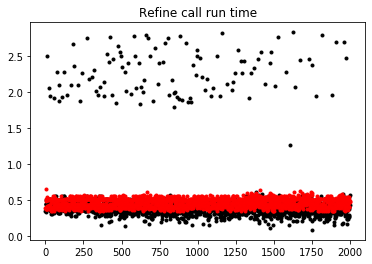

In [8]:
pp.plot(run_timeP2_ML_list,'.k',GmresRunTimeOriginal2,'.r')
pp.title('Refine call run time')

Text(0.5, 1.0, 'Coarse call run time')

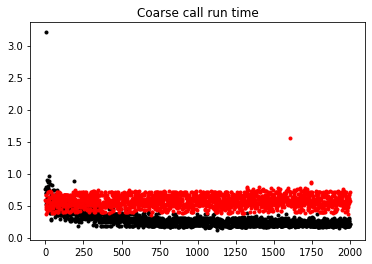

In [9]:
pp.plot(run_timeP1_ML_list,'.k',GmresRunTimeOriginal,'.r')
pp.title('Coarse call run time')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:65: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


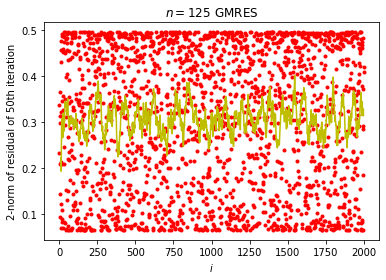

In [10]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[10:-1],AVG[10:-1],'y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ GMRES')
pp.savefig('GMRES.png')

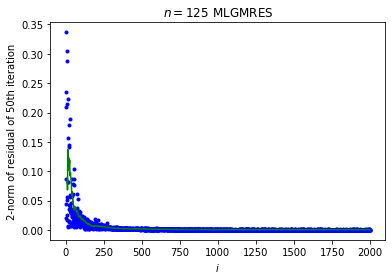

In [11]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('$n=125$ MLGMRES')
pp.savefig('MLGMRES.png')

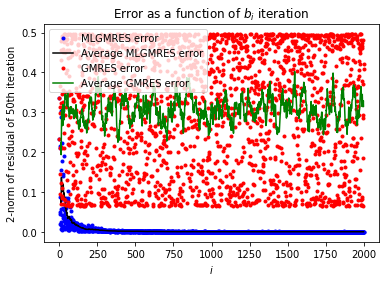

In [12]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 50th iteration')
pp.title('Error as a function of $b_i$ iteration ')
pp.legend(loc='best')
pp.savefig('Compare.png')

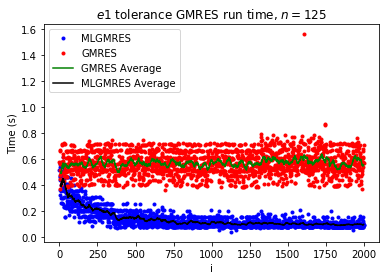

In [13]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')




pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n=125$')
pp.legend(loc='best')
pp.savefig('Runtime.png')